## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.

In [0]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
import os
os.chdir('/content/drive/My Drive/R9 External Lab')

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
project_path = '/content/drive/My Drive/R9 External Lab/'
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
!mkdir train

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile
with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')

In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist = []
masklist = []

In [0]:
imagelist = os.listdir(path = '/content/drive/My Drive/R9 External Lab/train/images')

In [0]:
masklist = os.listdir(path = '/content/drive/My Drive/R9 External Lab/train/masks')

In [0]:
#Test your list names by printing some of the names as given below.
imagelist[0:9]

['8d08955cdf.png',
 'e045664b46.png',
 '4989c6509e.png',
 'fff4eb4941.png',
 '3a310860a3.png',
 '7a696bb878.png',
 '8d3ee9356b.png',
 '213e0a9f7b.png',
 '78f17697f2.png']

In [0]:
masklist[0:9]

['8d08955cdf.png',
 'e045664b46.png',
 '4989c6509e.png',
 'fff4eb4941.png',
 '3a310860a3.png',
 '7a696bb878.png',
 '8d3ee9356b.png',
 '213e0a9f7b.png',
 '78f17697f2.png']

# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import matplotlib.pyplot as plt
import cv2

In [0]:
#plt.imshow(cv2.imread('/content/drive/My Drive/R9 External Lab/train/images/8d08955cdf.png'))

In [0]:
#plt.imshow(cv2.imread('/content/drive/My Drive/R9 External Lab/train/masks/8d08955cdf.png'))

First 5 images


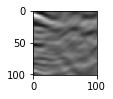

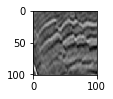

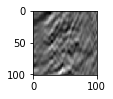

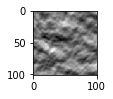

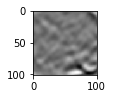

In [0]:
print("First 5 images")
for i, file in enumerate(imagelist[0:5]):
        plt.figure()
        ipath = path_train+ "images/" + file
        #print(fullpath)
        #print(i, file)
        img=cv2.imread(ipath)
        plt.subplot(326)
        plt.imshow(img)
        

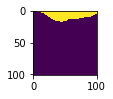

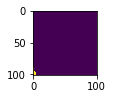

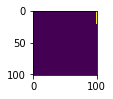

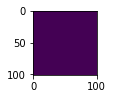

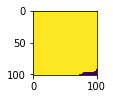

In [0]:
for i, file in enumerate(imagelist[0:5]):
        plt.figure()
        mpath = path_train+ "masks/" + file
        img=mpimg.imread(mpath)
        plt.subplot(325)
        plt.imshow(img)

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
X = []
for i in (imagelist): 
  image_path = os.path.join(path_train + "images/" + i)
  #print(image_path)
  X.append(image_path)
len(X)

4000

In [0]:
Y = []
for i in (masklist): 
  image_path = os.path.join(path_train + "masks/" + i)
  #print(image_path)
  Y.append(image_path)
len(Y)

4000

In [0]:
print(X[0:1])
print(Y[0:1])

['/content/drive/My Drive/R9 External Lab/train/images/8d08955cdf.png']
['/content/drive/My Drive/R9 External Lab/train/masks/8d08955cdf.png']


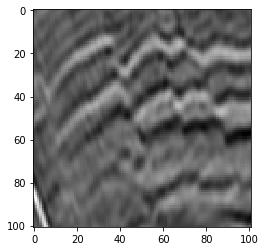

In [0]:
plt.imshow(cv2.imread(X[1]))

In [0]:
X[1]

'/content/drive/My Drive/R9 External Lab/train/images/e045664b46.png'

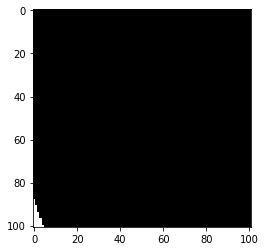

In [0]:
plt.imshow(cv2.imread(Y[1]))

In [0]:
batch_images = np.zeros((len(X),im_width, im_height, 3), dtype=np.float32)
for i, f in enumerate(X):
    img = Image.open(f) # Read image
    img = img.resize((im_width, im_height)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
batch_masks = np.zeros((len(Y),im_width, im_height, 3), dtype=np.float32)
for i, f in enumerate(Y):
    img = Image.open(f) # Read image
    img = img.resize((im_width, im_height)) # Resize image
    img = img.convert('RGB')
    batch_masks[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
batch_images[1]

array([[[-0.36470586, -0.36470586, -0.36470586],
        [-0.2862745 , -0.2862745 , -0.2862745 ],
        [-0.2862745 , -0.2862745 , -0.2862745 ],
        ...,
        [-0.3333333 , -0.3333333 , -0.3333333 ],
        [-0.3333333 , -0.3333333 , -0.3333333 ],
        [-0.3098039 , -0.3098039 , -0.3098039 ]],

       [[-0.30196077, -0.30196077, -0.30196077],
        [-0.23921567, -0.23921567, -0.23921567],
        [-0.23921567, -0.23921567, -0.23921567],
        ...,
        [-0.38039213, -0.38039213, -0.38039213],
        [-0.38039213, -0.38039213, -0.38039213],
        [-0.3333333 , -0.3333333 , -0.3333333 ]],

       [[-0.30196077, -0.30196077, -0.30196077],
        [-0.23921567, -0.23921567, -0.23921567],
        [-0.23921567, -0.23921567, -0.23921567],
        ...,
        [-0.38039213, -0.38039213, -0.38039213],
        [-0.38039213, -0.38039213, -0.38039213],
        [-0.3333333 , -0.3333333 , -0.3333333 ]],

       ...,

       [[-0.34117645, -0.34117645, -0.34117645],
        [-0

In [0]:
batch_masks[1]

array([[[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       ...,

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


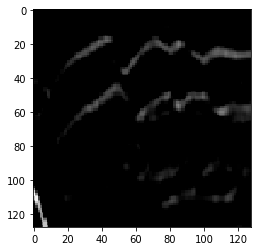

In [0]:
plt.imshow(batch_images[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


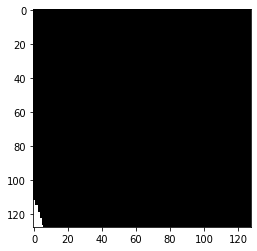

In [0]:
plt.imshow(batch_masks[1])

In [0]:
# Split train and valid

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, Y_val = train_test_split(batch_images,batch_masks, test_size = .30, random_state=00)

In [0]:
print("shape of training data:" , X_train.shape, y_train.shape)
print("shape of Validation data:" , X_val.shape, Y_val.shape)

shape of training data: (2800, 128, 128, 3) (2800, 128, 128, 3)
shape of Validation data: (1200, 128, 128, 3) (1200, 128, 128, 3)


In [0]:
## Test your data whether it looks fine - Random check
# Check if training data looks all right
## Already checked before! 

Not very sure why we are asked to split the images and masks into training and validation data. Have just followed the instruction without calrity as I am not sure how this data will be used further in this exercise. This assignment seem to end abrubtly. 

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
#Already Mounted

### Import Keras and other libraries

In [0]:

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
project_path = '/content/drive/My Drive/R9 External Lab/'

In [0]:
from zipfile import ZipFile
with ZipFile(project_path + 'data.zip', 'r') as zf:
  zf.extractall('nlp/')

In [0]:
project_path

'/content/drive/My Drive/R9 External Lab/'

In [0]:
filelist = []

In [0]:
filelist = os.listdir(path = '/content/drive/My Drive/R9 External Lab/nlp/data')

In [0]:
filelist

['For Love of the King.txt',
 'Salomé A tragedy in one act.txt',
 'Impressions of America.txt',
 'The Canterville Ghost.txt',
 'A House of Pomegranates.txt',
 'Miscellaneous Aphorisms_ The Soul of Man.txt',
 'A Woman of No Importance a play.txt',
 'Essays and Lectures.txt',
 'The Happy Prince and other tales.txt',
 'Rose Leaf and Apple Leaf.txt',
 'Vera or, The Nihilists.txt',
 'Lord Arthur Savile_s Crime.txt',
 'Poems with the Ballad of Reading Gaol.txt',
 'Selected poems of oscar wilde including The Ballad of Reading Gaol.txt',
 'Charmides and Other Poems.txt',
 'An Ideal Husband.txt',
 'The Duchess of Padua.txt',
 'Oscar Wilde Miscellaneous.txt',
 'The Ballad of Reading Gaol.txt',
 'Shorter Prose Pieces.txt',
 'Children in Prison and Other Cruelties of Prison Life.txt',
 'Reviews.txt',
 'A Critic in Pall Mall.txt',
 'De Profundis.txt',
 'Miscellanies.txt',
 'The Importance of Being Earnest.txt',
 'Selected prose of oscar wilde with a Preface by Robert Ross.txt',
 'The Soul of Man.t

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
content = []
for i, file in enumerate(filelist):
        #print(i, file)
        filename = '/content/drive/My Drive/R9 External Lab/nlp/data/'+file 
        with open(filename, 'r') as f:
            content = [line.strip() for line in f if line.strip()] #Removed the empty lines 
            f.close()

In [0]:
content = []
bookranges = []
for file in filelist:
    filename = '/content/drive/My Drive/R9 External Lab/nlp/data/'+file 
    text = open(filename, "r")
    start = len(content)
    content.append(text.read())
    end = len(content)
    bookranges.append({"start": start, "end": end, "name": file.rsplit("/", 1)[-1]})
    text.close()

In [0]:
len(content)

31

In [0]:
content

['\ufeffThe Project Gutenberg eBook, For Love of the King, by Oscar Wilde\n\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\n\n\n\nTitle: For Love of the King\n       a Burmese Masque\n\n\nAuthor: Oscar Wilde\n\n\n\nRelease Date: October 28, 2007  [eBook #23229]\n\nLanguage: English\n\nCharacter set encoding: ISO-646-US (US-ASCII)\n\n\n***START OF THE PROJECT GUTENBERG EBOOK FOR LOVE OF THE KING***\n\n\n\n\nTranscribed from the [1922] Methuen and Co./Jarrold and Sons edition by\nDavid Price, email ccx074@pglaf.org\n\n\n\n\n\nFOR\nLOVE OF THE KING\n\n\nA BURMESE MASQUE\n\nBY\nOSCAR WILDE\n\nMETHUEN & CO. LTD.\n36 ESSEX STREET W.C.\nLONDON\n\n_First Published by Methuen & Co. Ltd. in 1922_\n\n_This Edition on handmade paper is limited to 1000 copies_\n\n\n\n\nINTRODUCTORY NOTE\n\n

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(content)

In [0]:
print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)

OrderedDict([('\ufeffthe', 30), ('project', 2634), ('gutenberg', 2903), ('ebook', 324), ('for', 8728), ('love', 1326), ('of', 41415), ('the', 64874), ('king', 320), ('by', 5255), ('oscar', 182), ('wilde', 251), ('this', 4644), ('is', 17221), ('use', 743), ('anyone', 188), ('anywhere', 106), ('at', 5424), ('no', 3601), ('cost', 108), ('and', 35342), ('with', 9022), ('almost', 371), ('restrictions', 63), ('whatsoever', 99), ('you', 9737), ('may', 1871), ('copy', 425), ('it', 11877), ('give', 819), ('away', 751), ('or', 5791), ('re', 106), ('under', 627), ('terms', 687), ('license', 486), ('included', 113), ('online', 129), ('www', 291), ('org', 331), ('title', 106), ('a', 22045), ('burmese', 15), ('masque', 19), ('author', 195), ('release', 41), ('date', 137), ('october', 39), ('28', 20), ('2007', 2), ('23229', 4), ('language', 187), ('english', 557), ('character', 253), ('set', 600), ('encoding', 23), ('iso', 6), ('646', 6), ('us', 2170), ('ascii', 68), ('start', 125), ('transcribed', 2

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(content)

In [0]:
len(sequences)

31

In [0]:
sequences[0:10]

[[3244,
  52,
  47,
  365,
  14,
  96,
  2,
  1,
  372,
  26,
  656,
  474,
  27,
  365,
  7,
  14,
  1,
  162,
  2,
  624,
  1079,
  25,
  36,
  1058,
  3,
  13,
  317,
  36,
  1732,
  1145,
  11,
  72,
  273,
  10,
  142,
  10,
  154,
  21,
  1080,
  162,
  10,
  184,
  1,
  172,
  2,
  1,
  52,
  47,
  239,
  1027,
  13,
  27,
  365,
  21,
  906,
  25,
  413,
  47,
  355,
  1081,
  14,
  96,
  2,
  1,
  372,
  5,
  5214,
  4475,
  607,
  656,
  474,
  2490,
  863,
  2598,
  4328,
  15779,
  365,
  11349,
  628,
  213,
  471,
  200,
  3931,
  9006,
  9007,
  59,
  59,
  1621,
  938,
  2,
  1,
  52,
  47,
  365,
  14,
  96,
  2,
  1,
  372,
  3829,
  28,
  1,
  15780,
  2133,
  3,
  698,
  21344,
  3,
  1765,
  483,
  26,
  1856,
  982,
  1127,
  3932,
  916,
  355,
  14,
  96,
  2,
  1,
  372,
  5,
  5214,
  4475,
  26,
  656,
  474,
  2133,
  698,
  3531,
  4476,
  5215,
  594,
  1043,
  427,
  396,
  127,
  781,
  26,
  2133,
  698,
  3531,
  6,
  15780,
  27,
  483,
  23,
  5981,


### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

In [0]:
features[0]

[3244, 52, 47, 365, 14, 96, 2, 1, 372, 26, 656, 474, 27, 365, 7, 14, 1, 162, 2]

In [0]:
labels[0]

624

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# 80% training data
train_end = int(0.8 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [0]:
for i, sequence in enumerate(X_train[:5]):
    text = []
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: room in algernon's flat in half moon street the room is luxuriously and artistically furnished the sound of a

Label: piano

Features: a woman of no importance a play author oscar wilde release date september 16 2014 ebook 854 this file

Label: was

Features: with it martin was dismissed it happened in may last year he is still out of employment and in

Label: poor

Features: out of a mane of tawny clouds the muffled steersman at the wheel is but a shadow in the

Label: gloom

Features: encoding utf 8 start of the project gutenberg ebook oscar wilde miscellaneous transcribed from the 1917 methuen and co

Label: edition



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [0]:
model = Sequential()
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=200,
        weights=None,
        trainable=True))
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.15,
        recurrent_dropout=0.15))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         6567800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32839)             2134535   
Total params: 8,774,335
Trainable params: 8,774,335
Non-trainable params: 0
_______________________________________________________

For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [0]:
h = model.fit(X_train, y_train, epochs = 500, batch_size = 64, 
          verbose = 1)

Epoch 1/500
7440/7440 [==============================] - 5s 703us/step - loss: 1.7947 - acc: 0.6147
Epoch 2/500
7440/7440 [==============================] - 5s 692us/step - loss: 1.7684 - acc: 0.6175
Epoch 3/500
7440/7440 [==============================] - 5s 693us/step - loss: 1.7588 - acc: 0.6199
Epoch 4/500
7440/7440 [==============================] - 5s 698us/step - loss: 1.7781 - acc: 0.6134
Epoch 5/500
7440/7440 [==============================] - 5s 690us/step - loss: 1.7325 - acc: 0.6227
Epoch 6/500
7440/7440 [==============================] - 5s 700us/step - loss: 1.7630 - acc: 0.6147
Epoch 7/500
7440/7440 [==============================] - 5s 716us/step - loss: 1.7834 - acc: 0.6190
Epoch 8/500
7440/7440 [==============================] - 5s 698us/step - loss: 1.7680 - acc: 0.6183
Epoch 9/500
7440/7440 [==============================] - 5s 685us/step - loss: 1.7710 - acc: 0.6230
Epoch 10/500
7440/7440 [==============================] - 5s 700us/step - loss: 1.7661 - acc: 0.6181

### Save Model

In [0]:
# save the model to file
model.save('/content/drive/My Drive/R9 External Lab/nlp/model1.h5')

In [0]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

7440/7440 [==============================] - 5s 628us/step
[0.32740083948198345, 0.9470430038949494]

Model Performance: Log Loss and Accuracy on validation data
1860/1860 [==============================] - 1s 598us/step
[7.972473067622031, 0.3731182810439858]


## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
model = load_model('/content/drive/My Drive/R9 External Lab/nlp/model1.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [0]:
model.fit(X_train, y_train, batch_size=50, epochs=500)

Epoch 1/500
7440/7440 [==============================] - 7s 976us/step - loss: 1.2352 - acc: 0.7071
Epoch 2/500
7440/7440 [==============================] - 7s 889us/step - loss: 1.2388 - acc: 0.7069
Epoch 3/500
7440/7440 [==============================] - 7s 891us/step - loss: 1.2385 - acc: 0.7024
Epoch 4/500
7440/7440 [==============================] - 7s 902us/step - loss: 1.2172 - acc: 0.7073
Epoch 5/500
7440/7440 [==============================] - 7s 889us/step - loss: 1.2714 - acc: 0.7024
Epoch 6/500
7440/7440 [==============================] - 7s 909us/step - loss: 1.2402 - acc: 0.7095
Epoch 7/500
7440/7440 [==============================] - 7s 887us/step - loss: 1.2528 - acc: 0.7039
Epoch 8/500
7440/7440 [==============================] - 7s 886us/step - loss: 1.2054 - acc: 0.7105
Epoch 9/500
7440/7440 [==============================] - 7s 876us/step - loss: 1.2406 - acc: 0.7043
Epoch 10/500
7440/7440 [==============================] - 7s 893us/step - loss: 1.2139 - acc: 0.7095

## Evaluation

In [0]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

7440/7440 [==============================] - 5s 636us/step
[0.19900831058796656, 0.9658602089971624]

Model Performance: Log Loss and Accuracy on validation data
1860/1860 [==============================] - 1s 591us/step
[8.269627791579051, 0.3849462374884595]


## Generate text

In [0]:
seed_length=20
new_words=3
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
# print(gen_list)
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
# print(a)

Original Sequence: 
religious subjects in the naive spirit of the early florentine painters representing people of our own day in the dress


Generated Sequence: 
upon that de


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


In [0]:
model.save('/content/drive/My Drive/R9 External Lab/nlp/model2.h5')

In [0]:
model.predict(X_valid[0])

array([[1.91919880e-09, 1.24216045e-03, 8.77218481e-05, ...,
        1.91425609e-09, 1.91475991e-09, 1.91744975e-09],
       [5.62641600e-11, 0.00000000e+00, 1.72193791e-06, ...,
        5.62804733e-11, 5.66622027e-11, 5.54485242e-11],
       [1.02199444e-07, 4.92592715e-02, 2.52474342e-02, ...,
        1.02087228e-07, 1.02235319e-07, 1.02214258e-07],
       ...,
       [9.21436882e-09, 2.92042523e-06, 6.12834015e-08, ...,
        9.17672960e-09, 9.27817467e-09, 9.13945364e-09],
       [2.75068118e-07, 3.93083954e-10, 3.23500721e-13, ...,
        2.75133146e-07, 2.77166265e-07, 2.76431336e-07],
       [3.41131638e-08, 2.29453973e-11, 6.84006736e-05, ...,
        3.41188908e-08, 3.43282984e-08, 3.42790933e-08]], dtype=float32)